In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess

import sys
from copy import copy
import scipy
import imageio
sys.path.append("../")
import itertools
from scipy.stats import norm
import matplotlib.mlab as mlab
from mvgavg import mvgavg

save_folder = "G:/DREAM/from_github/thesis/Figures/LDA/"
import seaborn as sns

from random import randrange
from joblib import wrap_non_picklable_objects


from alienlab import utils
import alienlab
from alienlab import regression_func
import pickle as pk
from alienlab import plot
from activation_experiment import activation_experiment


import skimage.registration


from useful_func import dtw, get_path, plot_warped_timeseries
from useful_func import spectrum_a, spectrum_d
from useful_func import residuals, exp_decay, get_fit, sigmoid, exp_decay_max
from useful_func import gradient_magnitude, gradient_orientation, gaussian_kernel, assign_orientation, crop_center, cconv, get_algae_im
from numpy import genfromtxt

from joblib import Parallel, delayed
from useful_func import make_svm, make_pca
from sklearn.decomposition import PCA

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.stats as st


import sklearn
import sklearn.discriminant_analysis
import pandas as pd


import skimage

from useful_func import fit_biexp, fit_exp, fit_monoexp

import tifffile as tiff
import random
%matplotlib widget

g = plot.PlotFigure()
g.fontsize=17



In [2]:
lda = pk.load(open("lda.pkl",'rb'))
M_lda = np.genfromtxt("M_lda.csv")
S_lda = np.genfromtxt("S_lda.csv")
RTr = np.genfromtxt("RTr.csv")

def transform_data(data):
    #print(data.shape, transform.shape)
    data = (data.T - M_lda)/S_lda
    XT = np.dot(data, RTr.T)
    
    return XT


def save_david(traces_david, labels_david, desc, name):
    print(len(traces_david))
    print(len(labels_david))
    print(len(list(desc.keys())))
    np.savetxt("data_DAVID/"+name + "_labels.csv", np.concatenate(labels_david))
    np.savetxt("data_DAVID/"+ name + "_traces.csv", np.concatenate(traces_david))

    import json

    with open("data_DAVID/"+name + "_class_match.json", "w") as outfile:
        json.dump(desc, outfile)


def prepare_plot(database2):
        fig2, ax2 = plt.subplots(1, 3, figsize = (20, 8))
        labels = database2[-1]
        data = database2[:-2]
        XT =  transform_data(data)

        lower_bounds = np.quantile(XT, 0.019, axis = 0)
        upper_bounds = np.quantile(XT, 0.99, axis = 0)

        for label in [1,2,3]:
            ind = labels == label
            X = XT[ind]
            description = all_descriptions[0][ind][0]
            plot_points(X, description, ax2, lower_bounds, upper_bounds)

        return ax2, lower_bounds, upper_bounds

In [3]:
def get_traces_from_couples(list_of_couples, traces):
    v0 = np.expand_dims(traces[:,250], 1)
    traces_0 = (v0 - traces[:,list_of_couples[0]])/traces[:,list_of_couples[0]]
    traces_1 = (v0 - traces[:,list_of_couples[1]])/traces[:,list_of_couples[1]]
    traces = traces_1 - traces_0
    return traces


def get_couple_of_measure(exps):
    #liste_pair = list(itertools.combinations(np.linspace(250, 2050, 91).astype(int), 2))
    liste_pair = list(itertools.combinations([250, 270, 290, 410, 1110,  1130, 1150, 1170, 2050], 2))

    traces, labels, times = elem.get_traces_and_times(exps)

    traces = get_traces_from_couples(list_of_couples, traces)
    return traces

In [4]:
def plot_points(X, description, ax2, lower_bounds, upper_bounds):
    
    select = abs(X - np.mean(X, axis = 0)) < 3 * np.std(X, axis = 0)
    select = select.min(axis = 1)

    ax2[0].scatter(X[select,0], X[select,1], label = description)
    ax2[0].scatter(np.mean(X[select,0]), np.mean(X[select,1]), color = "k")

    ax2[0].set_xlabel('x - qT', fontsize=17)
    ax2[0].set_ylabel('y - qE', fontsize=17)
    ax2[0].set_xlim(lower_bounds[0], upper_bounds[0])
    ax2[0].set_ylim(lower_bounds[1], upper_bounds[1])

    ax2[1].scatter(X[select,0], X[select,2], label = description)
    ax2[1].scatter(np.mean(X[select,0]), np.mean(X[select,2]), color = "k")

    ax2[1].set_xlabel('x - qT', fontsize=17)
    ax2[1].set_ylabel('z - qI', fontsize=17)
    ax2[1].set_xlim(lower_bounds[0], upper_bounds[0])
    ax2[1].set_ylim(lower_bounds[2], upper_bounds[2])

    ax2[2].scatter(X[select,1], X[select,2], label = description)
    ax2[2].scatter(np.mean(X[select,1]), np.mean(X[select,2]), color = "k")

    ax2[2].set_xlabel('y - qE', fontsize=17)
    ax2[2].set_ylabel('z - qI', fontsize=17)
    ax2[2].set_xlim(lower_bounds[1], upper_bounds[1])
    ax2[2].set_ylim(lower_bounds[2], upper_bounds[2])

    ax2[0].legend(prop = {"size": 15})
    ax2[0].axis("off")
    ax2[1].legend(prop = {"size": 15})
    ax2[2].legend(prop = {"size": 15})

    x = X[select,0]
    y =  X[select,1]

    # Define the borders
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)

    f = np.reshape(kernel(positions).T, xx.shape)


    #plt.imshow(z)

    cfset = ax2[0].contour(xx, yy, f, levels=1, alpha=1)
    #ax2[0].imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    #cset = ax.contour(xx, yy, f, colors='k')
    #ax.clabel(cset, inline=1, fontsize=10)


In [5]:
liste_pair = list(itertools.combinations(np.linspace(250, 2050, 91).astype(int), 2))
liste_pair = list(itertools.combinations([250, 270, 290, 410, 1110,  1130, 1150, 1170, 2050], 2))

list_of_couples = list(zip(*liste_pair))
positions_to_keep = np.ones(len(liste_pair),dtype=int)#np.load("positions_to_keep.npy")

In [6]:
def follow_the_trace(elem_list,  ref_mask, savename, qI = False):
    
    couples = np.array(liste_pair)[positions_to_keep]
    @delayed
    @wrap_non_picklable_objects
    def get_ratio_from_video(start_vid, F0, F1, transform, mask_flat):
            video = imageio.get_reader(start_vid)
            frame_250 = skimage.transform.warp(video.get_data(250), transform)
            frame_F0 =  skimage.transform.warp(video.get_data(F0), transform)
            frame_F1 = skimage.transform.warp(video.get_data(F1), transform)
            r0  = (frame_250 - frame_F0)/frame_F0
            r1 = (frame_250 - frame_F1)/frame_F1
            diff = r1-r0
            diff = np.nan_to_num(diff, neginf=0, nan=0, posinf=0) 
            return diff.flatten()[mask_flat!=0]



    
    
    ims = []
    for m in range(len(elem_list)):
        if qI == False:
            video = elem_list[m] + "/video.tiff"
            n0 = 0
            n1 = 1
        else:
            n0 = 0
            n1 = 2
            video = elem_list[m] + "/video.tiff"

        video = imageio.get_reader(video)
        ims.append(video.get_data(250))


    ims_sum = np.sum(np.array(ims), axis = 0)
    plt.figure()
    plt.imshow(ims_sum)
    plt.title("shifted")
    plt.savefig(savename + ".png")
    
    # unique mask
    if qI == False:
        exp_data = ref_mask + "/items_dict.npy"
    else:
        exp_data = ref_mask + "/items_dict.npy"
    exp_data = np.load(exp_data, allow_pickle=True).item()
    mask = exp_data["labels"]

    mask_flat = mask.flatten()

    transforms = []


    diffs = []
    

    for j in range(len(elem_list)):
        shift, error, diffphase = skimage.registration.phase_cross_correlation(ims[j], ims[0], upsample_factor=100)
        shift = np.roll(shift,1)
        tform = skimage.transform.AffineTransform(translation = shift)
        transforms.append(tform)
        ims[j] = skimage.transform.warp(ims[j], tform)*255
        #masks.append(skimage.transform.warp(mask, tform))
        #mask_j = skimage.transform.warp(mask, tform)
        if qI == False:
            video = elem_list[j] + "/video.tiff"
        else:
            video = elem_list[j] + "/video.tiff"

       
        diff = Parallel(n_jobs = -1 )(get_ratio_from_video(video, couple[0], couple[1], tform, mask_flat) for couple in couples)
        diff = np.array(diff)
        diffs.append(diff)
        print(diff.shape)
    diffs = np.array(diffs)

    ims_sum = np.sum(np.array(ims), axis = 0)
    plt.figure()
    plt.imshow(ims_sum)
    plt.title("corrected shift")

    diff_labels = []
    for label in np.unique(mask):
        s = np.sum(mask==label)
        if label !=0 and s>5:# and s<60:
            diff_labels.append(np.mean(diffs[:,:,mask_flat[mask_flat!=0]==label], axis = -1))

    diff_labels = np.array(diff_labels)
    diff_labels.shape
    return diff_labels, mask

In [18]:
labels_david = []
traces_david = []

traces_noise = []

desc = {}
k = 0
name = "WT4_2H"
plt.figure()

    

for folder in ["FOLDER_2022_07_08_CC124_1_3h",
              "FOLDER_2022_07_07_CC124_not_sync_2H",
               "FOLDER_2022_04_07_stt71_scl3_monoclonal_synchro_ENS_4H",
               "FOLDER_2022_04_06_stt71_scl1_monoclonal_synchro_ENS_4H",
               "FOLDER_2022_04_05_WT4_monoclonal_synchro_ENS_4H",
               "FOLDER_2022_03_31_STT71_polyculture_slow_activateion_45min",
               "FOLDER_2022_03_30_4H_ENS_CC_124_sync",
               "FOLDER_2022_03_29_4H_ENS_CC_124_sync",
               "FOLDER_2022_03_25_wt4_activated_IBPC_sync",
               "FOLDER_2022_03_24_stt71_activated_IBPC_sync",
               "FOLDER_2022_03_23_npq4_activated_IBPC_sync",
               "FOLDER_2022_03_16_WT222_SC1",
               "FOLDER_2022_03_15_WT222_OLD",
               "FOLDER_2022_03_10_activation_4H_ENS_stt7",
               "FOLDER_2022_03_09_activation_4H_ENS_npq4",
               "FOLDER_2022_03_08_activation_4H_ENS_wt4",
               "FOLDER_2022_02_24_HL_chunks_stt71",
               "FOLDER_2022_02_23_HL_chunks_npq4",
               "FOLDER_2022_02_22_HL_chuncks_WT4"
              ]:
    for i in [0]:#,1,2]:
    
            elem = activation_experiment("../" + folder)
            save_name = "noise_study/" + os.path.split(folder)[1] + "_ACT"
            if (len(elem.measure[0])>2)*(len(elem.measure[1])>2):
            
                measure = elem.measure[0:2][-1]
                traces, labels, times = elem.get_traces_and_times(measure)
                traces_david.append(traces)
                labels_david.append(np.array([k]*traces.shape[0]))
                desc[k] = "WT4_activated_%dH_%dmin"%((80*k)//60, (120*k)%60)
                blabla, mask = follow_the_trace(measure, ref_mask = elem.measure[0][-1], savename = save_name, qI = False)
                np.save(save_name + "_trace_trajectory", blabla)
                traces_noise.append(blabla.T)
                #traces = transform_data(blabla.T)
                #traces_noise.append(traces)
                #plt.plot(traces[:,:,0], traces[:,:,1], ".", label = 0)
                k+= 1
       # except:
       #     pass
plt.legend()
plt.close("all")


(36, 1396)
(36, 1396)
(36, 1396)
(36, 1396)
(36, 5841)
(36, 5841)
(36, 5841)
(36, 5841)
(36, 7410)
(36, 7410)
(36, 7410)
(36, 7410)
(36, 11015)
(36, 11015)
(36, 11015)
(36, 11015)
(36, 4909)
(36, 4909)
(36, 4909)
(36, 4909)
(36, 9114)
(36, 9114)
(36, 9114)
(36, 9114)
(36, 5630)
(36, 5630)
(36, 5630)
(36, 5630)
(36, 18395)
(36, 18395)
(36, 18395)


C:\Users\Alienor\AppData\Local\Temp\ipykernel_24468\4038928344.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


(36, 2292)
(36, 2292)
(36, 2292)
(36, 2292)
(36, 5479)
(36, 5479)
(36, 5479)
(36, 5479)
(36, 8272)
(36, 8272)
(36, 8272)
(36, 21616)
(36, 21616)
(36, 21616)
(36, 21616)
(36, 5527)
(36, 5527)
(36, 5527)
(36, 5527)
(36, 4439)
(36, 4439)
(36, 4439)
(36, 4439)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## single cell

## Population

ValueError: operands could not be broadcast together with shapes (29,4,36) (4095,) 

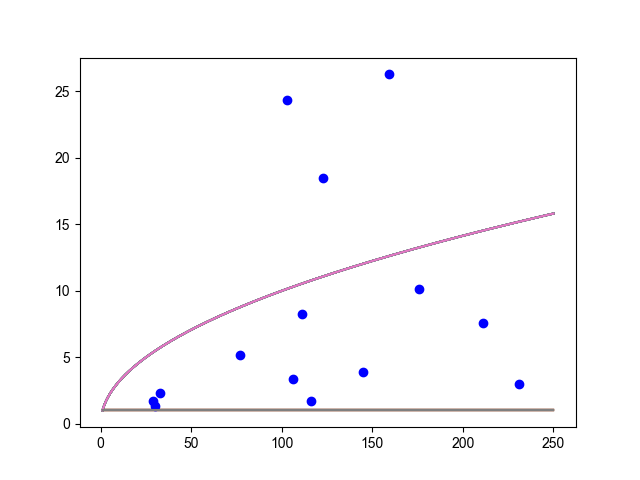

In [7]:
plt.figure()
for i in range(1,3):
    for f in glob.glob("noise_study/*_%d_*.npy"%i):


        blabla = np.load(f)
        traces = transform_data(blabla.T)
        traces = traces[:,:,0:2]
        local_noise = traces[:,0]-traces[:,1]
        local_noise = np.sqrt(np.sum(local_noise**2, axis = 1))
        local_noise = np.mean(local_noise)#/np.sqrt(len(traces))
        #plt.hist(local_noise)

        pop_noise = np.mean(traces, axis = 0)
        pop_noise = pop_noise[0] - pop_noise[1]
        pop_noise = np.sqrt(np.sum(pop_noise**2))
        #plt.scatter(local_noise, pop_noise, label  = f[-50:-21])
        plt.plot(len(traces), local_noise/pop_noise, ["ok", "ob", "or"][i], label  = f[-50:-21])
        x = np.linspace(1, 250, 1000)
        plt.plot(x,np.sqrt(x))
        plt.plot(x,np.ones(x.shape))


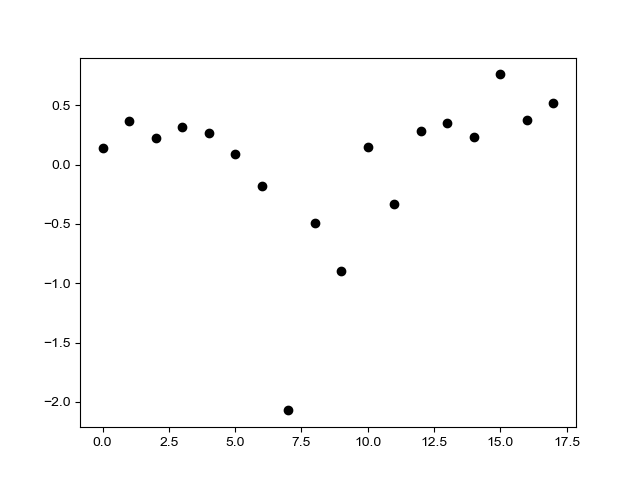

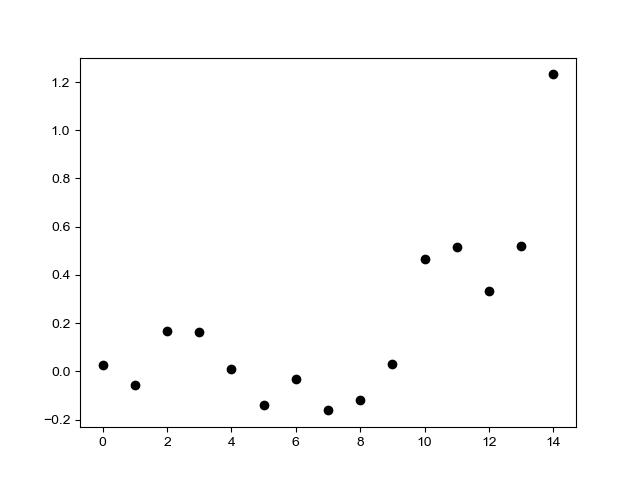

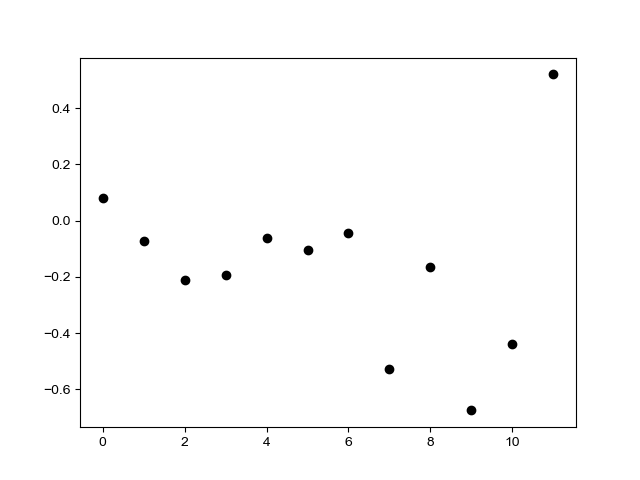

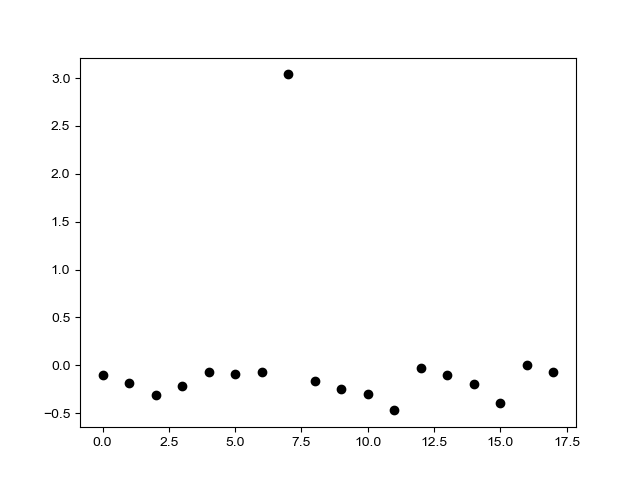

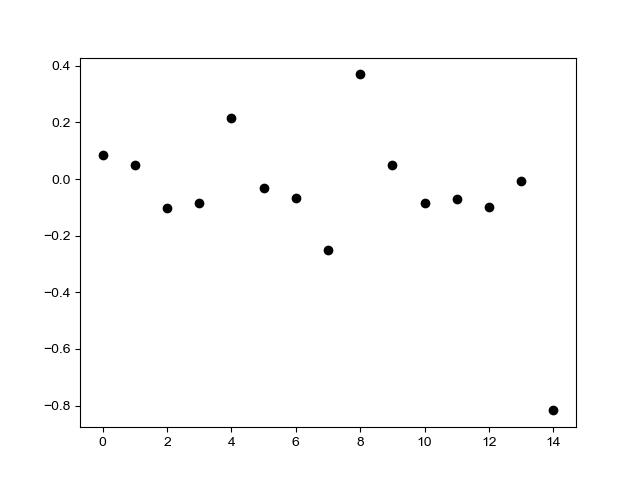

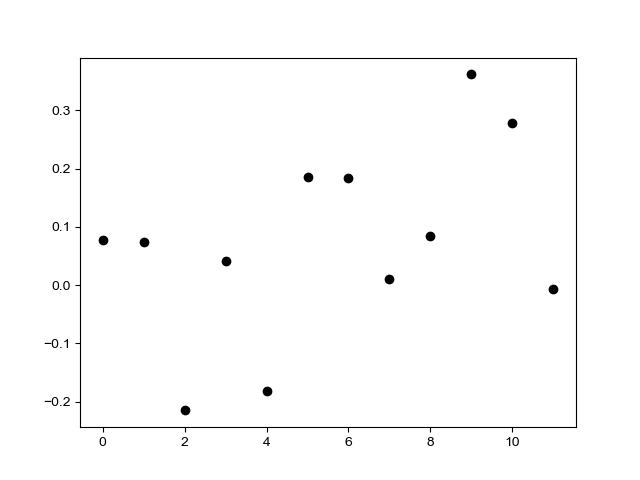

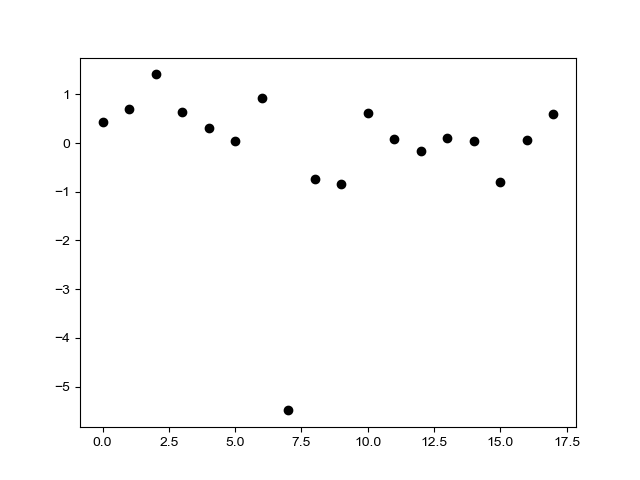

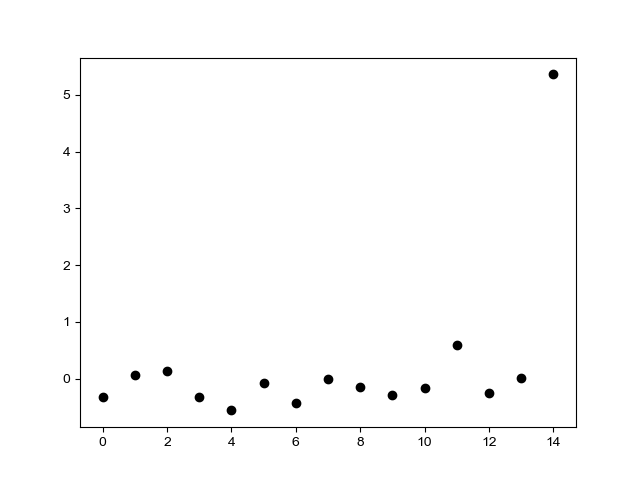

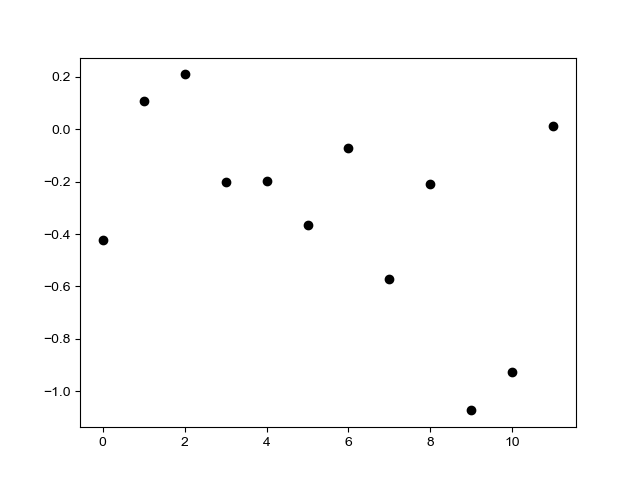

In [11]:
for i in range(0,3):
    for k in range(0,3):
        plt.figure()
        for u, f in enumerate(glob.glob("noise_study/*_%d_*.npy"%k)):
            blabla = np.load(f)
            traces = transform_data(blabla.T)
            plt.plot(u, np.mean(traces[:,0,i] - traces[:,1,i]), "ok")

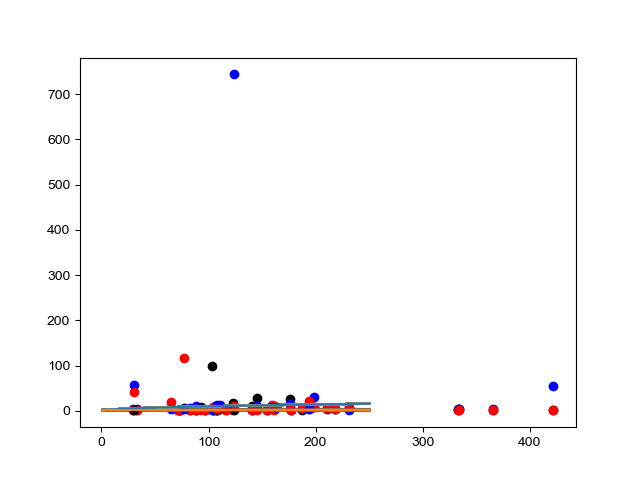

In [108]:
plt.figure()
for f in glob.glob("noise_study/*.npy"):
    for i in range(3):

        blabla = np.load(f)
        traces = transform_data(blabla.T)
        traces = traces[:,:,i:i+1]
        local_noise = traces[:,0]-traces[:,1]
        local_noise = np.sqrt(np.sum(local_noise**2, axis = 1))
        local_noise = np.mean(local_noise)#/np.sqrt(len(traces))
        #plt.hist(local_noise)

        pop_noise = np.mean(traces, axis = 0)
        pop_noise = pop_noise[0] - pop_noise[1]
        pop_noise = np.sqrt(np.sum(pop_noise**2))
        #plt.scatter(local_noise, pop_noise, label  = f[-50:-21])
        plt.plot(len(traces), local_noise/pop_noise, ["ok", "ob", "or"][i], label  = f[-50:-21])
        x = np.linspace(1, 250, 1000)
        plt.plot(x,np.sqrt(x))
        plt.plot(x,np.ones(x.shape))

#plt.legend()

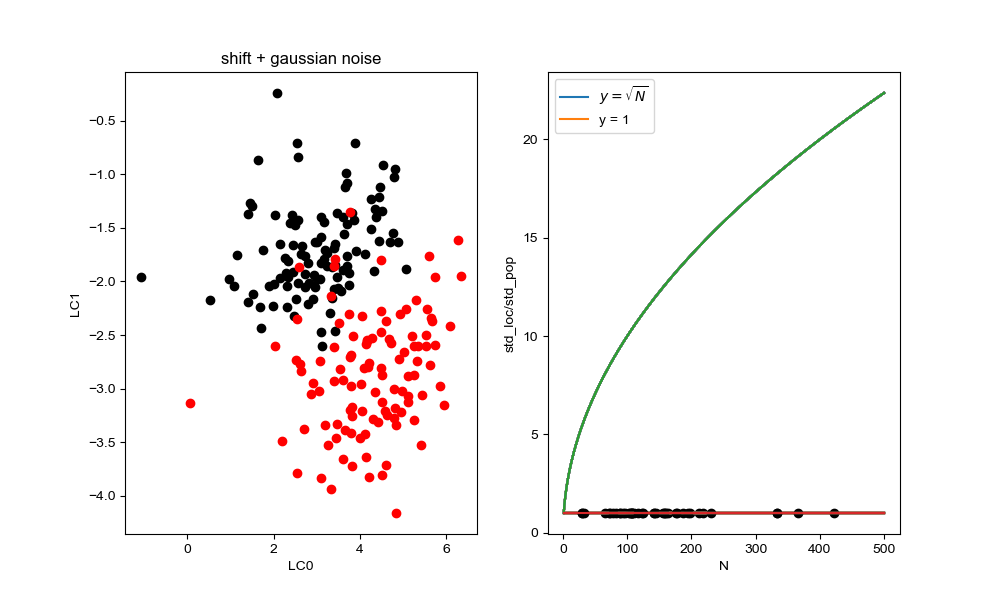

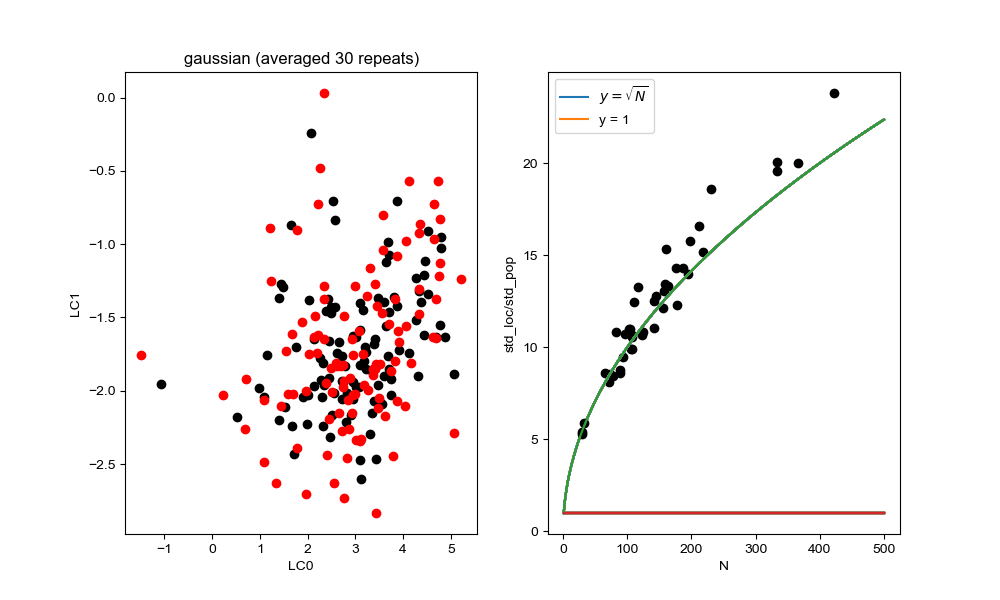

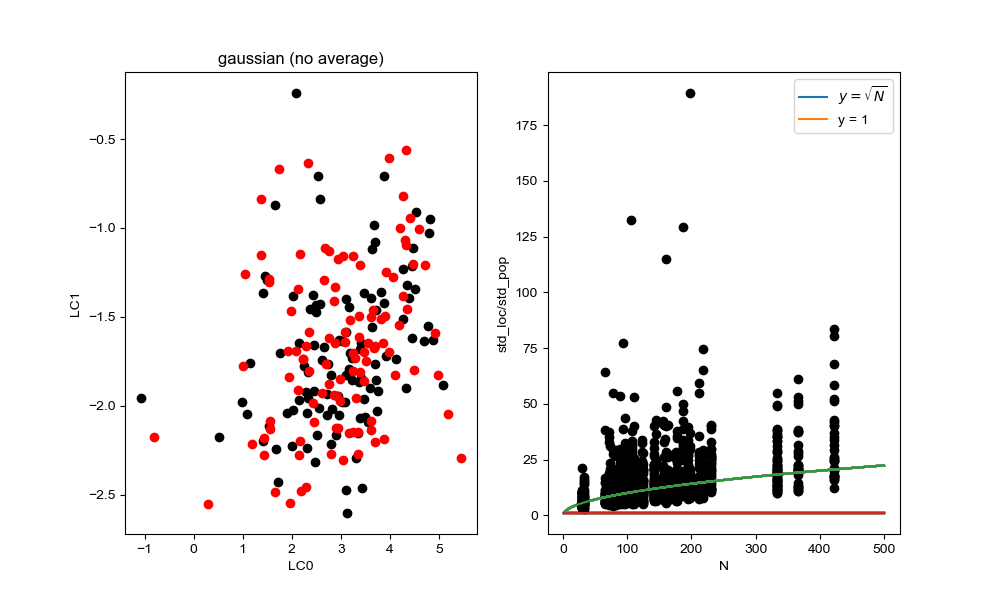

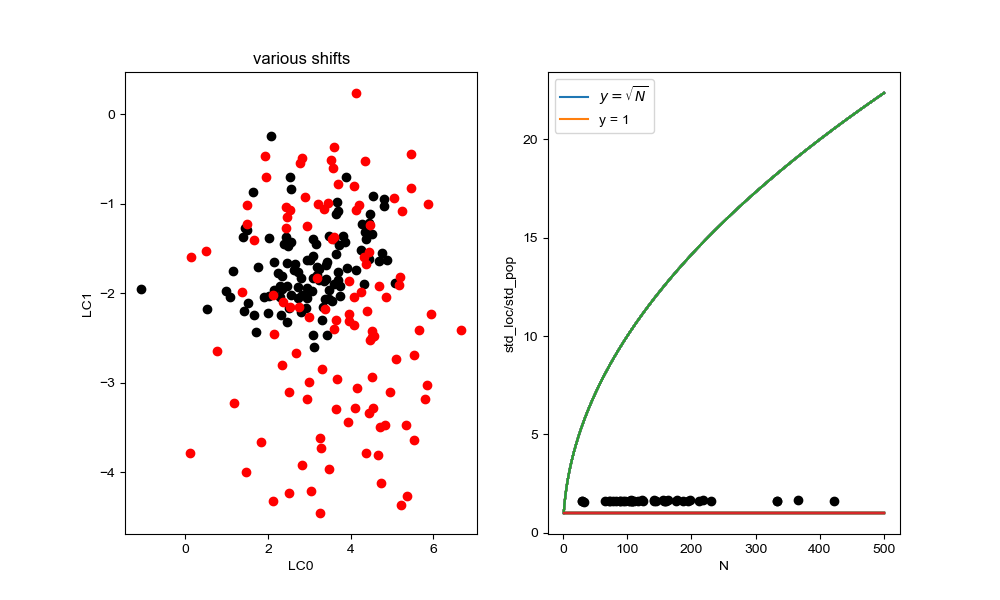

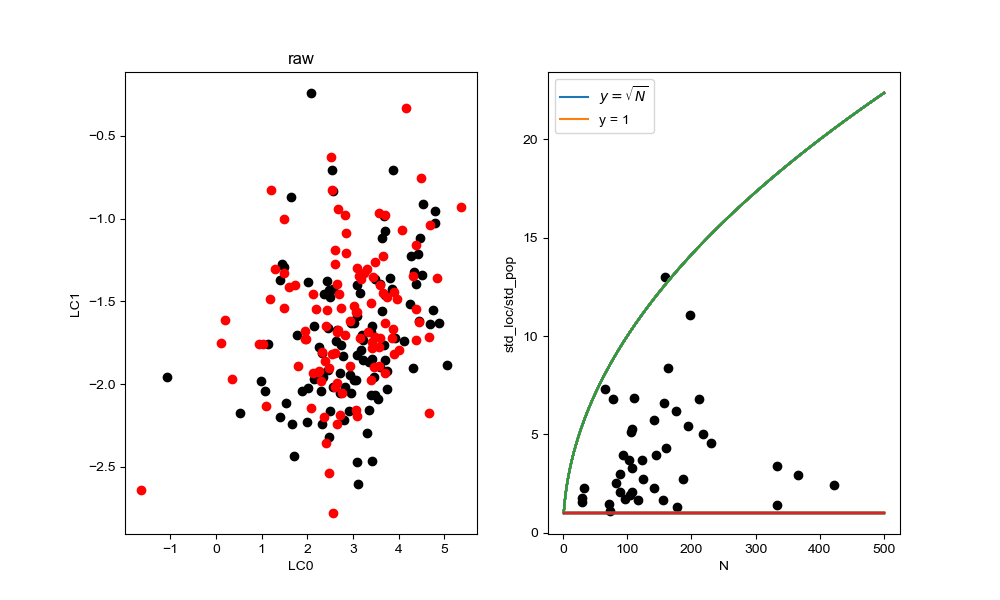

In [102]:

for k, case in enumerate(["shift + gaussian noise", "gaussian (averaged 30 repeats)", "gaussian (no average)", "various shifts", "raw"]):
    fig, axs = plt.subplots(1, 2, figsize = (10, 6))

    for i, f in enumerate(glob.glob("noise_study/*.npy")):
        Mpop = []
        Mloc = []
        for u in range([3, 30, 30, 30, 1][k]):


            blabla = np.load(f)
            traces = transform_data(blabla.T)
            M = np.mean(T, axis=0)/2
            N, P, V = traces.shape
            if k==0:
                D = np.random.rand(N,V)-0.5 + 3*M
                traces[:,1] = traces[:,0] + D
                
            if k in [1,2]:
                D = np.random.rand(N,V)-0.5
                traces[:,1] = traces[:,0] + D     
            
            if k==3:
                D = 3*np.expand_dims(M, 0)*np.random.rand(N,1) + 3* (np.random.rand(N,V)-0.5)
                traces[:,1] = traces[:,0] + D     

            if u==0 and i==0:
                axs[0].plot(traces[:,0,0], traces[:,0,1], "ok")
                axs[0].plot(traces[:,1,0], traces[:,1,1], "or" )

            local_noise = traces[:,0]-traces[:,1]
            local_noise = np.sqrt(np.sum(local_noise**2, axis = 1))
            local_noise = np.mean(local_noise)#/np.sqrt(len(traces))
            Mloc.append(local_noise)
            #plt.hist(local_noise)

            pop_noise = np.mean(traces, axis = 0)
            pop_noise = pop_noise[0] - pop_noise[1]
            pop_noise = np.sqrt(np.sum(pop_noise**2))
            Mpop.append(pop_noise)
            
            if k==2:
                axs[1].plot(len(traces), local_noise/pop_noise, "ok")#,  label  = f[-50:-21])

                
                

        #plt.scatter(local_noise, pop_noise, label  = f[-50:-21])
        axs[1].plot(len(traces), np.mean(Mloc)/np.mean(Mpop), "ok")#,  label  = f[-50:-21])
        x = np.linspace(1, 500, 1000)
        if i==0:
            axs[1].plot(x,np.sqrt(x), label = r"$y =\sqrt{N}$")
            axs[1].plot(x,np.ones(x.shape), label = "y = 1")
        else:
            axs[1].plot(x,np.sqrt(x))
            axs[1].plot(x,np.ones(x.shape))
    axs[1].set_xlabel("N")
    axs[1].set_ylabel("std_loc/std_pop")

    axs[0].set_title(case)
    axs[0].set_xlabel("LC0")
    axs[0].set_ylabel("LC1")
    axs[1].legend()
    plt.savefig(case + ".png")
    
#plt.legend()

In [100]:
D.shape

(30, 3)

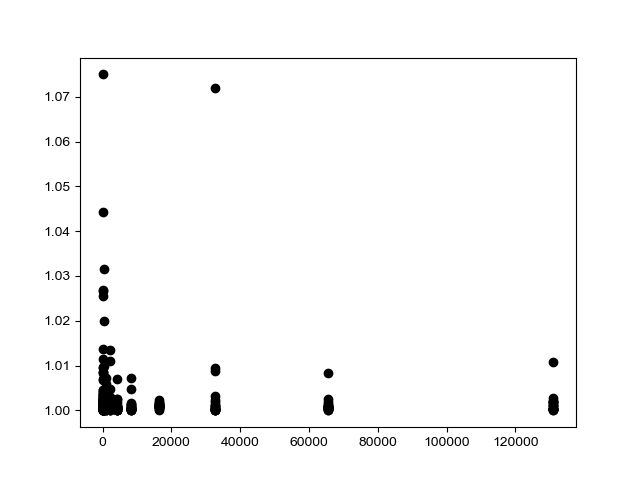

In [64]:
plt.figure()
for u in range(20):
    for n in range(1, 18):
        N = 2**n

        N, P, V = N, 2, 3
        A = np.random.rand(N, V)*10
        D = np.random.rand(N,V)-0.5
        #plt.plot(traces[:,0,0], traces[:,0,1], "ok")
        #plt.plot(traces[:,1,0], traces[:,1,1], "ob" )
        #plt.plot(traces[:,0,0]+D[:,0], traces[:,0,1] + D[:,1], "or")
        traces = np.array([A,A+D])
        
        local_noise = traces[:,0]-traces[:,1]
        local_noise = np.sqrt(np.sum(local_noise**2, axis = 1))
        local_noise = np.mean(local_noise)#/np.sqrt(len(traces))
        #plt.hist(local_noise)

        pop_noise = np.mean(traces, axis = 0)
        pop_noise = pop_noise[0] - pop_noise[1]
        pop_noise = np.sqrt(np.sum(pop_noise**2))
        #plt.scatter(local_noise, pop_noise, label  = f[-50:-21])
        plt.plot(N, local_noise/pop_noise, "ok",  label  = f[-50:-21])
        x = np.linspace(1, 250, 1000)
        #plt.plot(x,np.sqrt(x))
        plt.plot(x,np.ones(x.shape))
        
#plt.legend()

## Activation


noise_study\FOLDER_2022_03_08_activation_4H_ENS_wt4_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_03_15_WT222_OLD_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_03_16_WT222_SC1_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_03_29_4H_ENS_CC_124_sync_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_04_05_WT4_monoclonal_synchro_ENS_4H_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_04_06_stt71_scl1_monoclonal_synchro_ENS_4H_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_04_07_stt71_scl3_monoclonal_synchro_ENS_4H_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_07_07_CC124_not_sync_2H_ACT_trace_trajectory.npy
noise_study\FOLDER_2022_07_08_CC124_1_3h_ACT_trace_trajectory.npy


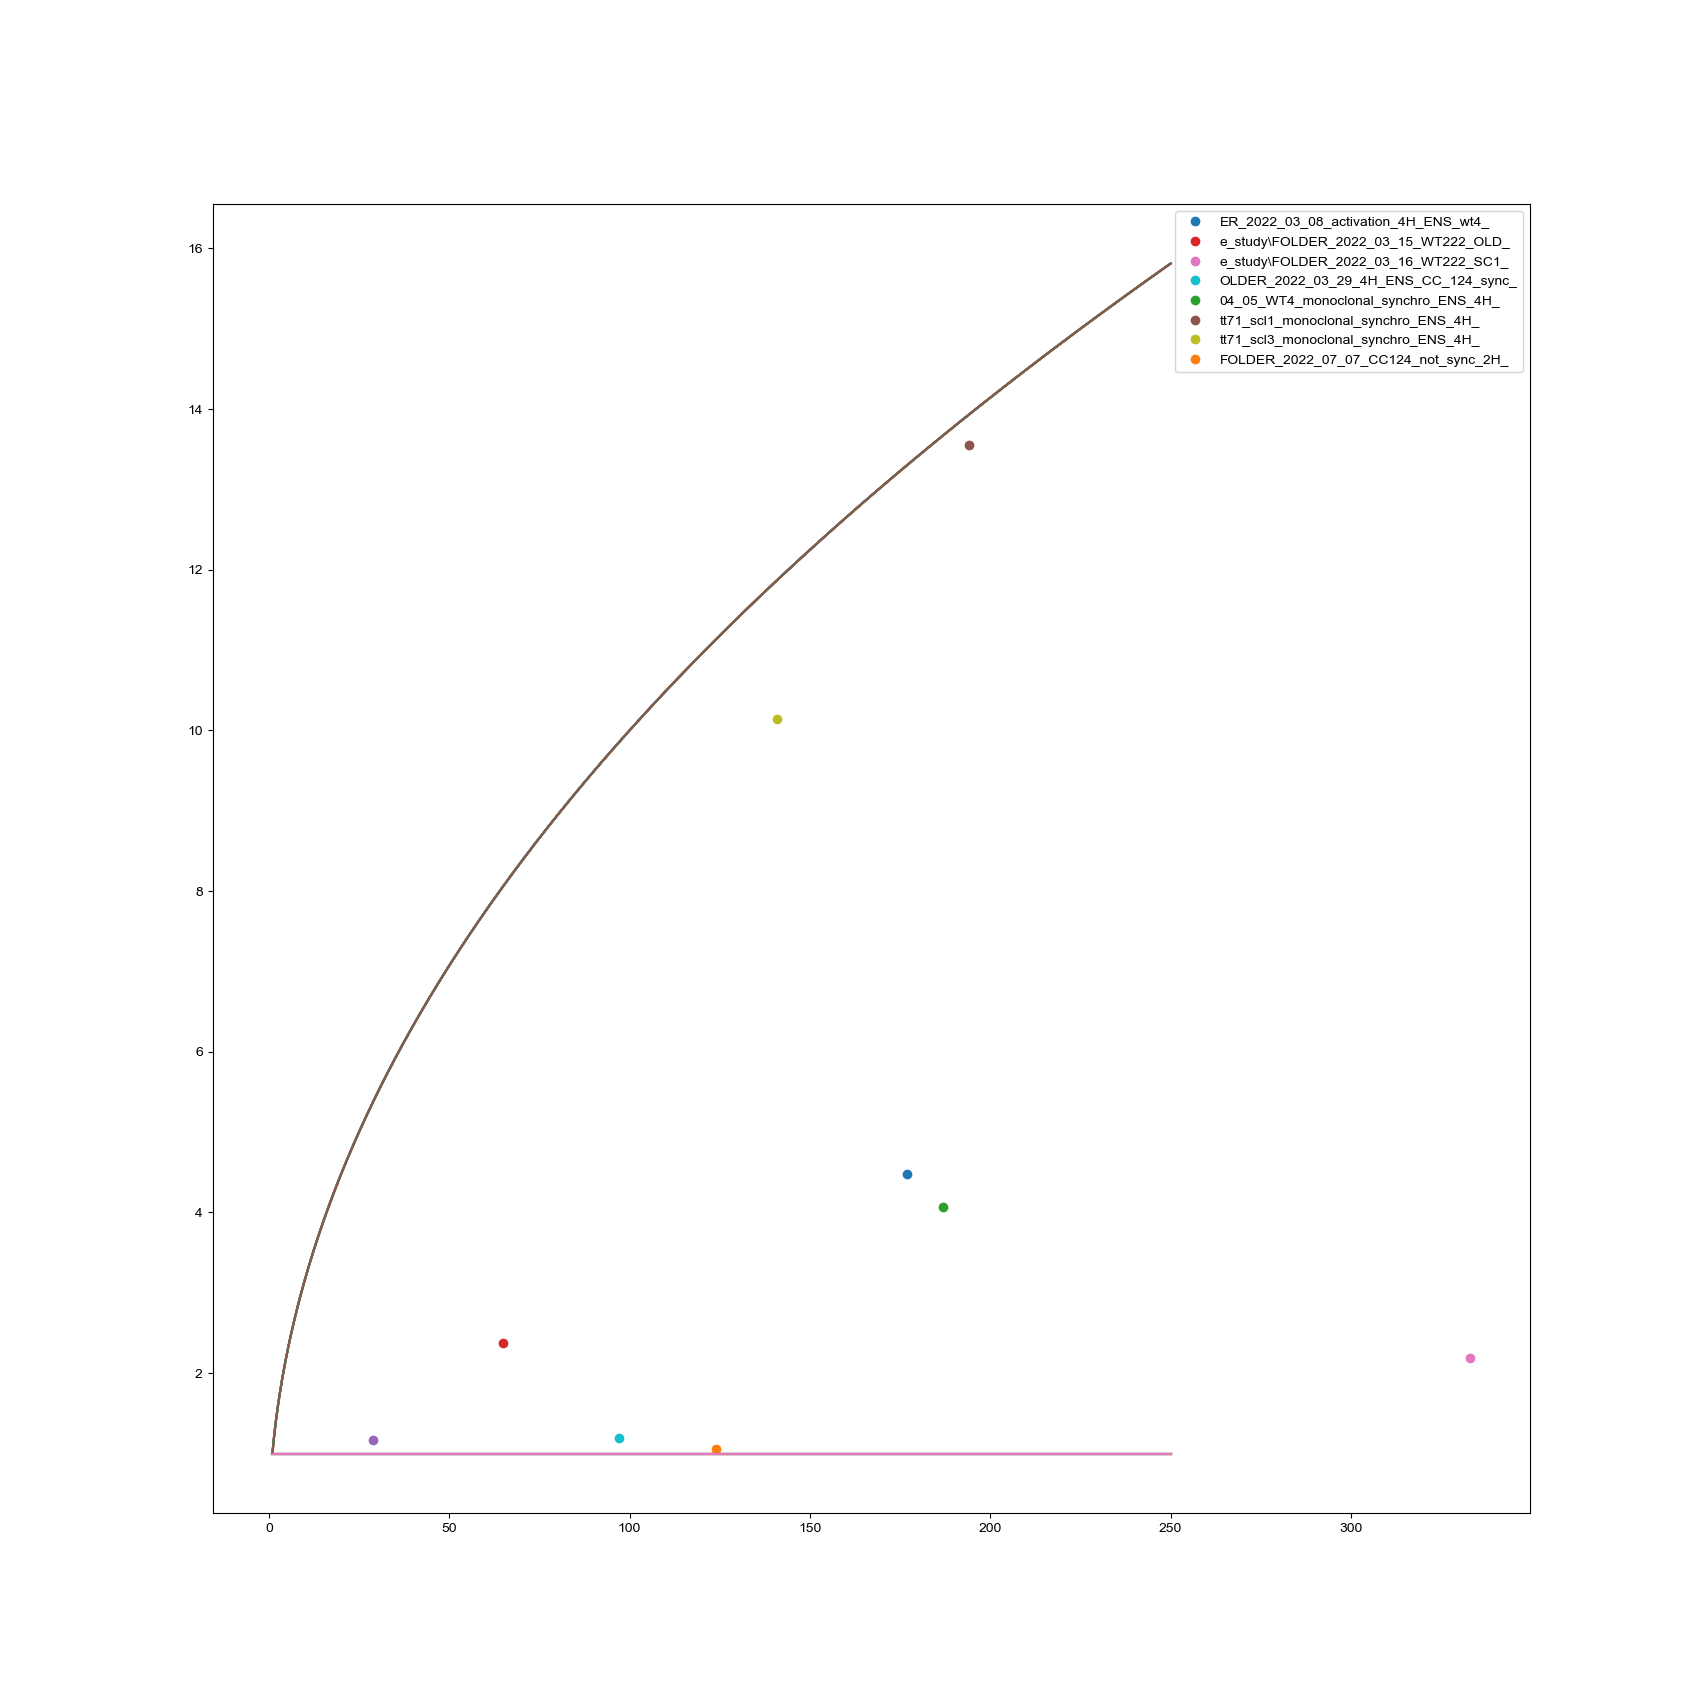

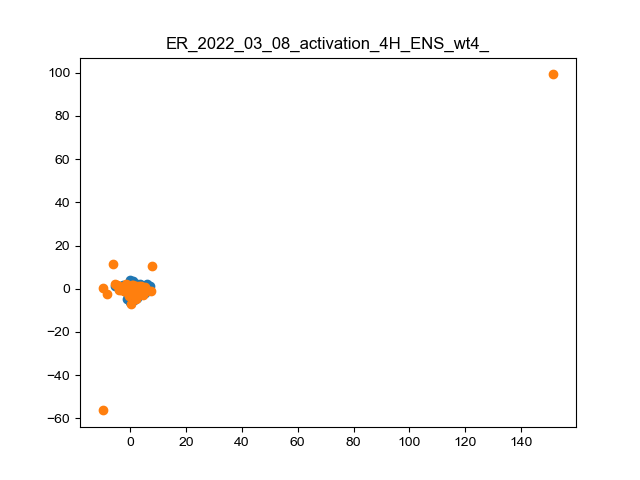

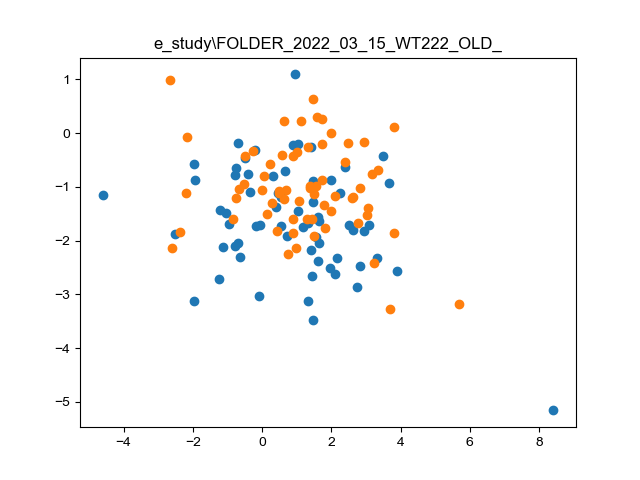

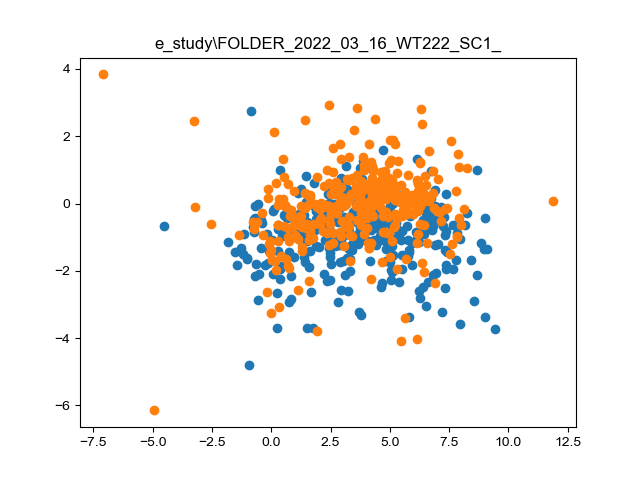

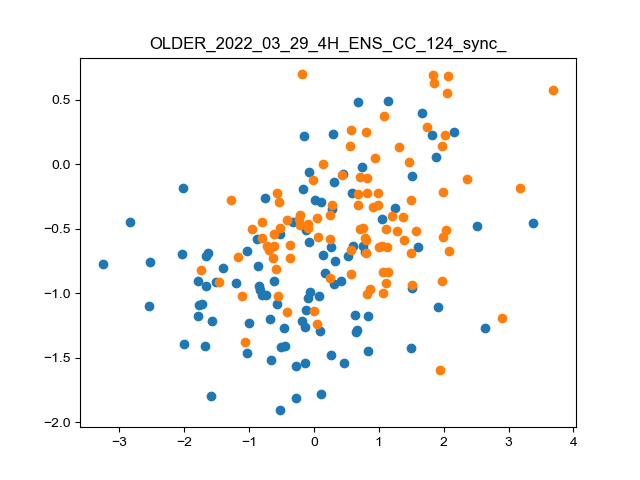

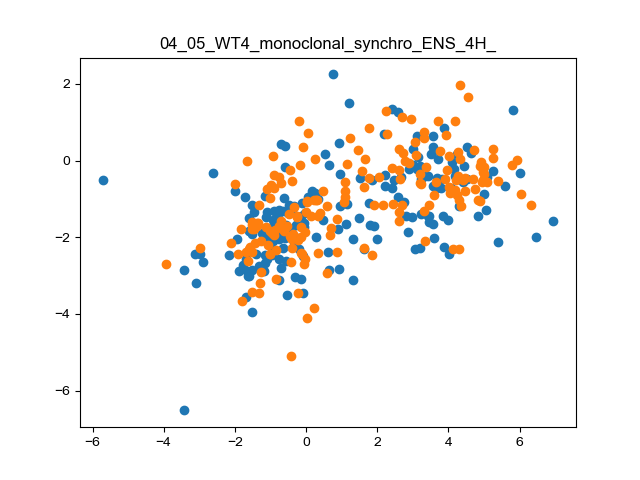

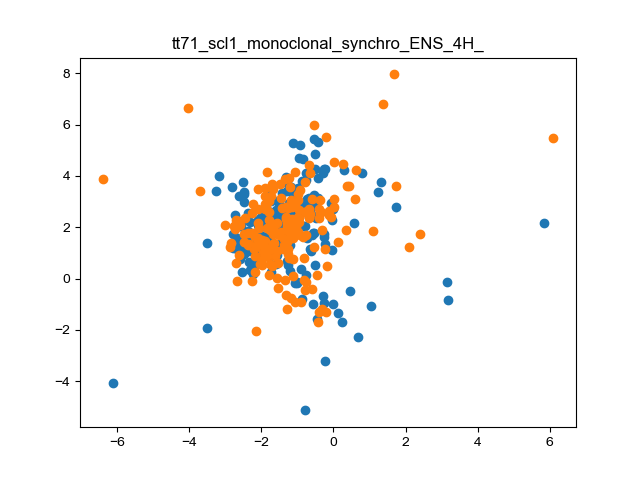

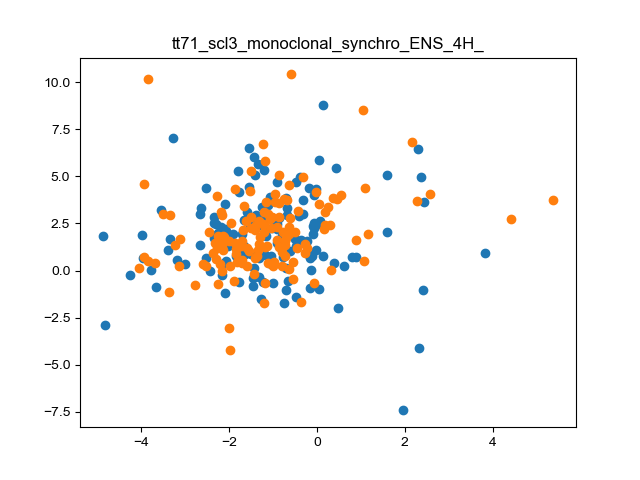

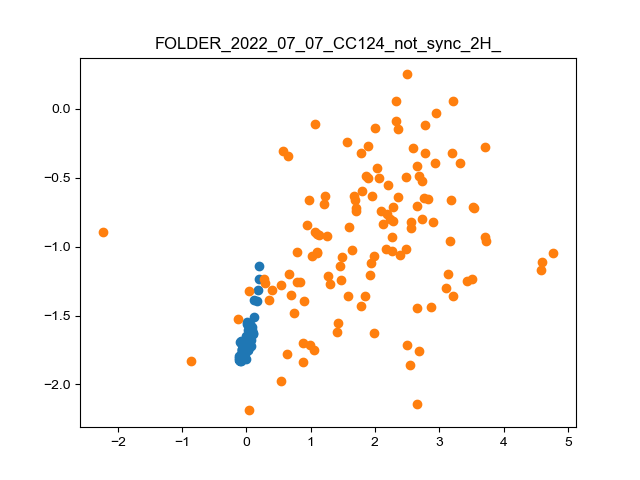

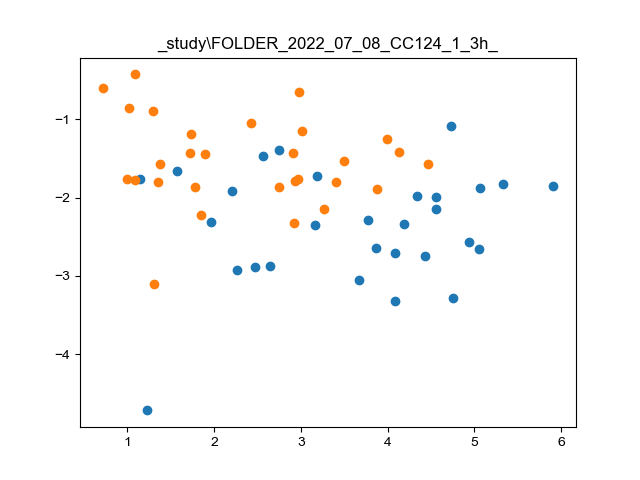

In [26]:
fig = plt.figure(figsize=(17,17))
ax1 = plt.gca()
for f in glob.glob("noise_study/*_ACT_*.npy"):
    print(f)

    blabla = np.load(f)
    traces = transform_data(blabla.T)
    traces = traces[:,:,0:2]
    local_noise = traces[:,0]-traces[:,1]
    local_noise = np.sqrt(np.sum(local_noise**2, axis = 1))
    local_noise = np.mean(local_noise)#/np.sqrt(len(traces))
    #plt.hist(local_noise)

    pop_noise = np.mean(traces, axis = 0)
    pop_noise = pop_noise[0] - pop_noise[1]
    pop_noise = np.sqrt(np.sum(pop_noise**2))
    #plt.scatter(local_noise, pop_noise, label  = f[-50:-21])
    ax1.plot(len(traces), local_noise/pop_noise, "o", label  = f[-60:-24])
    
    fig2 = plt.figure()
    ax2 = plt.gca()
    ax2.scatter(traces[:,0,0], traces[:,0,1]) 
    ax2.scatter(traces[:,1,0], traces[:,1,1]) 
    ax2.set_title(f[-60:-24])

    x = np.linspace(1, 250, 1000)
    ax1.plot(x,np.sqrt(x))
    ax1.plot(x,np.ones(x.shape))
    
    ax1.legend()
